# DS Master Class
## Car price prediction zorganizowany przez DataWorkshop



### 👉 SCHEMAT DZIAŁANIA - 10 kroków do wykonania. 

1. Import bibliotek 
2. Wczytanie i połączenie danych
3. Wykorzystanie cech z poprzednich notebooków
4. Trenujemy model 
5. Szukamy nowych cech - eskperymentujemy 
6. Trenujemy model 
7. Szukamy nowych cech - eksperymentujemy
8. Trenujemy model 
9. Porównujemy z naszym ostatnim wynikiem
10. Wrzucamy na Kaggle, jeśli poprawiliśmy wynik 💪


## 1️ Importujemy biblioteki 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from tqdm import tqdm
import helper as h

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import re

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 2️ Pobieramy i łączymy dane 

In [3]:
df = h.get_df(df_train, df_test)

(160257, 86)


In [ ]:
df_train = pd.read_hdf("../input/df.train.h5")
df_train["price_value"] = df_train['price_value'].map(h.parse_price)

df_test = pd.read_hdf("../input/df.test.h5")

print(df_train.shape, df_test.shape)

In [5]:
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['Bezwypadkowy_cat',
 'Liczba miejsc_cat',
 'Kraj pochodzenia_cat',
 'Pojemność skokowa_cat',
 'Rodzaj paliwa_cat',
 'Skrzynia biegów_cat',
 'Możliwość finansowania_cat',
 'Pierwszy właściciel_cat',
 'Oferta od_cat',
 'Liczba drzwi_cat',
 'Przebieg_cat',
 'Moc_cat',
 'Metalik_cat',
 'Typ_cat',
 'Kolor_cat',
 'Model pojazdu_cat',
 'Stan_cat',
 'Kategoria_cat',
 'Serwisowany w ASO_cat',
 'Napęd_cat',
 'Leasing_cat',
 'Rok produkcji_cat',
 'Marka pojazdu_cat',
 'Faktura VAT_cat',
 'Pierwsza rejestracja_cat',
 'Zarejestrowany w Polsce_cat',
 'VAT marża_cat',
 'Wersja_cat',
 'VIN_cat',
 'Perłowy_cat',
 'Uszkodzony_cat',
 'Kod Silnika_cat',
 'Filtr cząstek stałych_cat',
 'Emisja CO2_cat',
 'Miesięczna rata_cat',
 'Liczba pozostałych rat_cat',
 'Opłata początkowa_cat',
 'Wartość wykupu_cat',
 'Akryl (niemetalizowany)_cat',
 'Tuning_cat',
 'Kierownica po prawej (Anglik)_cat',
 'Homologacja ciężarowa_cat',
 'Make_cat',
 'Metallic_cat',
 'Engine capacity_cat',
 'Version_cat',
 'VAT discount_cat'

## 3️ Cechy 
Wczytujemy cechy, które już znamy i wiemy, że nam pomagają (poprzednie notebooki). 

In [6]:
df["year_production"] = df["Rok produkcji"].astype(int)
df["year_production_ext"] = df.apply(lambda x: x["year_production"] if x["year_production"] != -1 else int(x["Year"]), axis=1)

df["version_years"] = df["Wersja"].map(lambda x: re.findall(r'(\d+)-(\d+)?', str(x)) )

df["version_year_from"] = df["version_years"].map(lambda x: x[0][0] if x else -1).astype(int)
df["version_year_to"] = df["version_years"].map(lambda x: x[0][1] if x and x[0][1] != "" else -1).astype(int)

## 4️ Тrenowanie modelu

In [7]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(9789.400117714915, 304.4233545141454)


Weight,Feature
0.4162,year_production_ext
0.1616,Napęd_cat
0.0435,Skrzynia biegów_cat
0.0366,Serwisowany w ASO_cat
0.0299,Uszkodzony_cat
0.0270,Typ_cat
0.0259,Faktura VAT_cat
0.0227,Bezwypadkowy_cat
0.0199,Kierownica po prawej (Anglik)_cat
0.0146,Perłowy_cat


## 5️ Poszukiwanie nowych cech & eskperymentowanie 

In [8]:
df["Pojemność skokowa"]

0         1 199 cm3
1         1 598 cm3
2         1 364 cm3
3         1 798 cm3
4         1 250 cm3
            ...    
160245    2 000 cm3
160246      998 cm3
160247    1 600 cm3
160251    1 560 cm3
160254    3 301 cm3
Name: Pojemność skokowa, Length: 160257, dtype: object

<AxesSubplot:>

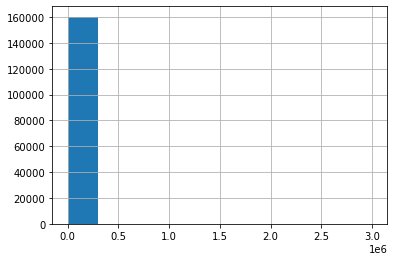

In [7]:
df["engine"] = df["Pojemność skokowa"].map(lambda x: str(x).split("cm3")[0].replace(" ", "")).astype("int")
df["engine"].hist()



Musimy trochę popracować z wartościami odstającymi. Milion to zbyt duża wartość. A co jeśli ustawimy `-1` dla wartości większych niż 99% (udajemy, że ich nie ma) 👀.

In [8]:
def reset_outlires(df, feat, prc=99):
    cut_value = np.percentile(df[feat], prc)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

Sprawdzamy, co się stało. 

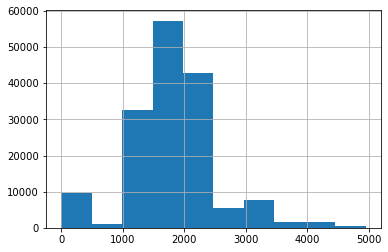

In [9]:
reset_outlires(df, "engine").hist();

df["engine_99"] = reset_outlires(df, "engine")

In [12]:
df["Moc"]

0         110 KM
1         117 KM
2          90 KM
3         160 KM
4          82 KM
           ...  
160245    170 KM
160246     69 KM
160247    105 KM
160251     92 KM
160254    174 KM
Name: Moc, Length: 160257, dtype: object

In [10]:
df["horse_power"] = df["Moc"].map(lambda x: str(x).split("KM")[0].replace(" ", "")).astype("int")

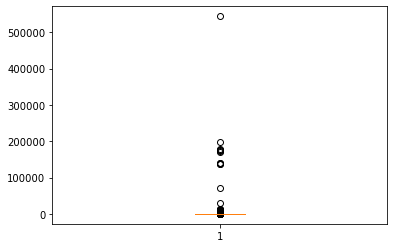

In [18]:
import matplotlib.pyplot as plt
plt.boxplot(df["horse_power"]);

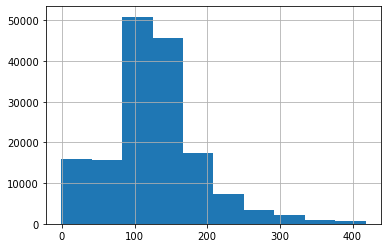

In [11]:
reset_outlires(df, "horse_power").hist();

df["horse_power_99"] = reset_outlires(df, "horse_power")

## 6️ Тrenujemy model

Dodajmy dwie nowe cechy i przekonajmy się, na ile nam to pomoże. 

In [20]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
feats += ["engine_99", "horse_power_99"]

h.check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

(8745.349328577238, 147.44902414858714)


Weight,Feature
0.3553,year_production_ext
0.1864,Napęd_cat
0.1097,Skrzynia biegów_cat
0.0460,horse_power_99
0.0297,Serwisowany w ASO_cat
0.0275,Uszkodzony_cat
0.0257,Kierownica po prawej (Anglik)_cat
0.0199,Faktura VAT_cat
0.0195,Typ_cat
0.0179,engine_99


## 7️ Poszukiwanie nowych cech & eskperymentowanie 🤖


In [21]:
# Sprawdzam kilka początkowych wierszy danych
df.head()

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat,year_production,year_production_ext,version_years,version_year_from,version_year_to,engine,engine_99,horse_power,horse_power_99
0,7,"Cena Brutto, Faktura VAT",63900.000,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",TRANS-AUTO SP. Z O.O. DEALER MARKI ...,Dealer,"ŁUKASIEWICZA 1 - 19-300 Ełk, ełcki, Warmińsko-...","[Osobowe, Citroën, C4 Cactus]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",Tak,5,Polska,1 199 cm3,Benzyna,Manualna,Tak,Tak,Firmy,5,200 km,110 KM,Tak,Kompakt,Czarny,C4 Cactus,Używane,Osobowe,Tak,Na przednie koła,Tak,2017,Citroën,Tak,15 listopad 2017,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017,2017,[],-1,-1,1199,1199,110,110
1,10,Cena Brutto,41900.000,PLN,"[ABS, ASR (kontrola trakcji), Elektryczne szyb...",DECAR - RENAULT i DACIA,Dealer,"MODLIŃSKA 154 B - 03-170 Warszawa, Mazowieckie...","[Osobowe, Nissan, Juke]","{'Kolor': 'Czarny', 'Model pojazdu': 'Juke', '...",-1,5,Polska,1 598 cm3,Benzyna,Automatyczna bezstopniowa (CVT),Tak,Tak,Firmy,5,118 808 km,117 KM,-1,SUV,Czarny,Juke,Używane,Osobowe,-1,-1,-1,2012,Nissan,-1,15 czerwiec 2012,Tak,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
# sprawdzam przebieg - główne informacje opisowe
df['Przebieg'].describe()

count     160257
unique     33496
top         1 km
freq        6132
Name: Przebieg, dtype: object

In [25]:
# przykładowe dane
df['Przebieg'].sample(10)

62543      50 000 km
10492           5 km
79629     110 911 km
136733    174 157 km
58705           1 km
26389     214 000 km
83121     210 000 km
30412     121 000 km
132942    174 000 km
61267     268 000 km
Name: Przebieg, dtype: object

In [12]:
# dane są typu object, zatem model z nich nie skorzysta. Konwertuję je na dane liczbowe - integer
df["Przebieg_liczba"] = df["Przebieg"].map(lambda x: str(x).split("km")[0].replace(" ", "")).astype("int")
df["Przebieg_liczba"].describe()

count     160257.000
mean      144008.106
std       125035.486
min           -1.000
25%        67500.000
50%       154000.000
75%       205000.000
max     14600690.000
Name: Przebieg_liczba, dtype: float64

In [13]:
# Przebieg 14600690.000, to chyba pomyłka. Sprawdzam
df[df['Przebieg_liczba'] == 14600690.000]

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat,year_production,year_production_ext,version_years,version_year_from,version_year_to,engine,engine_99,horse_power,horse_power_99,Przebieg_liczba
147817,147817,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Chodzież, chodzieski, Wielkopolskie","[Osobowe, Renault, Scenic, Renault Scenic II (...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",Tak,5,-1,1 900 cm3,Diesel,Manualna,-1,-1,Osoby prywatnej,5,14 600 690 km,100 KM,Tak,Minivan,Szary,Scenic,Używane,Osobowe,Tak,Na przednie koła,-1,2004,Renault,-1,-1,Tak,-1,II (2003 - 2009),VF1JMRG0631866293,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,2,7,1,0,1,1,1,0,32463,65,0,5,5,186,0,0,0,0,1,15,9,1,2,0,0,59,33862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2004,2004,[],-1,-1,1900,1900,100,100,14600690


In [14]:
# Renault Scenik i 14 mln przebiegu, jakie auto by dało radę?

df["Przebieg_liczba"] = reset_outlires(df, "Przebieg_liczba")
df["Przebieg_liczba"].describe()

# Wygląda lepiej :-)

count   160257.000
mean    138345.137
std      89021.442
min         -1.000
25%      61234.000
50%     151235.000
75%     202000.000
max     351749.000
Name: Przebieg_liczba, dtype: float64

In [15]:
# Liczba miejsc
df['Liczba_miejsc_val'] = df['Liczba miejsc'].map(lambda x: int(x))
df['Liczba_miejsc_val']

0         5
1         5
2         5
3         5
4         5
         ..
160245   -1
160246    4
160247    5
160251    5
160254    7
Name: Liczba_miejsc_val, Length: 160257, dtype: int64

In [53]:
# Kolumna features. Sprawdzam wszystkie rodzaje wyposażenia

all_wyposazenie = set()
_ = df['features'].map(lambda x: 'empty' if str(x) == 'nan' else all_wyposazenie.update(x))

all_wyposazenie

{'ABS',
 'ASR (kontrola trakcji)',
 'Alarm',
 'Alufelgi',
 'Asystent parkowania',
 'Asystent pasa ruchu',
 'Bluetooth',
 'CD',
 'Centralny zamek',
 'Czujnik deszczu',
 'Czujnik martwego pola',
 'Czujnik zmierzchu',
 'Czujniki parkowania przednie',
 'Czujniki parkowania tylne',
 'Dach panoramiczny',
 'ESP (stabilizacja toru jazdy)',
 'Elektrochromatyczne lusterka boczne',
 'Elektrochromatyczne lusterko wsteczne',
 'Elektryczne szyby przednie',
 'Elektryczne szyby tylne',
 'Elektrycznie ustawiane fotele',
 'Elektrycznie ustawiane lusterka',
 'Gniazdo AUX',
 'Gniazdo SD',
 'Gniazdo USB',
 'HUD (wyświetlacz przezierny)',
 'Hak',
 'Immobilizer',
 'Isofix',
 'Kamera cofania',
 'Klimatyzacja automatyczna',
 'Klimatyzacja czterostrefowa',
 'Klimatyzacja dwustrefowa',
 'Klimatyzacja manualna',
 'Komputer pokładowy',
 'Kurtyny powietrzne',
 'MP3',
 'Nawigacja GPS',
 'Odtwarzacz DVD',
 'Ogranicznik prędkości',
 'Ogrzewanie postojowe',
 'Podgrzewana przednia szyba',
 'Podgrzewane lusterka boczne',

In [62]:
def features_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'wyposazenie_{0}'.format(name.lower().strip().replace(' ', '_'))
    
features_series = df['features'].map(features_to_set)

for feat in all_wyposazenie:
    df[ norm_name(feat) ] = features_series.map(lambda x: feat in x)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat,year_production,year_production_ext,version_years,version_year_from,version_year_to,engine,engine_99,horse_power,horse_power_99,Przebieg_liczba,Liczba miejsc_val,Liczba_miejsc_val,wyposazenie_abs,wyposazenie_gniazdo_usb,wyposazenie_esp_(stabilizacja_toru_jazdy),wyposazenie_elektrochromatyczne_lusterka_boczne,wyposazenie_tapicerka_skórzana,wyposazenie_alarm,wyposazenie_hud_(wyświetlacz_przezierny),wyposazenie_odtwarzacz_dvd,wyposazenie_wielofunkcyjna_kierownica,wyposazenie_asr_(kontrola_trakcji),wyposazenie_światła_xenonowe,wyposazenie_podgrzewana_przednia_szyba,wyposazenie_czujnik_deszczu,wyposazenie_nawigacja_gps,wyposazenie_klimatyzacja_automatyczna,wyposazenie_łopatki_zmiany_biegów,wyposazenie_klimatyzacja_manualna,wyposazenie_klimatyzacja_dwustrefowa,wyposazenie_dach_panoramiczny,wyposazenie_elektryczne_szyby_przednie,wyposazenie_asystent_parkowania,wyposazenie_podgrzewane_przednie_siedzenia,wyposazenie_światła_do_jazdy_dziennej,wyposazenie_radio_fabryczne,wyposazenie_kurtyny_powietrzne,wyposazenie_system_start-stop,wyposazenie_relingi_dachowe,wyposazenie_czujnik_zmierzchu,wyposazenie_elektryczne_szyby_tylne,wyposazenie_poduszki_boczne_tylne,wyposazenie_poduszka_powietrzna_kierowcy,wyposazenie_czujniki_parkowania_tylne,wyposazenie_poduszki_boczne_przednie,wyposazenie_isofix,wyposazenie_zmieniarka_cd,wyposazenie_światła_led,wyposazenie_hak,wyposazenie_poduszka_powietrzna_chroniąca_kolana,wyposazenie_regulowane_zawieszenie,wyposazenie_tuner_tv,wyposazenie_asystent_pasa_ruchu,wyposazenie_tempomat,wyposazenie_gniazdo_aux,wyposazenie_wspomaganie_kierownicy,wyposazen

In [65]:
df[ [norm_name(x) for x in all_wyposazenie] ].head(5)


,wyposazenie_abs,wyposazenie_gniazdo_usb,wyposazenie_esp_(stabilizacja_toru_jazdy),wyposazenie_elektrochromatyczne_lusterka_boczne,wyposazenie_tapicerka_skórzana,wyposazenie_alarm,wyposazenie_hud_(wyświetlacz_przezierny),wyposazenie_odtwarzacz_dvd,wyposazenie_wielofunkcyjna_kierownica,wyposazenie_asr_(kontrola_trakcji),wyposazenie_światła_xenonowe,wyposazenie_podgrzewana_przednia_szyba,wyposazenie_czujnik_deszczu,wyposazenie_nawigacja_gps,wyposazenie_klimatyzacja_automatyczna,wyposazenie_łopatki_zmiany_biegów,wyposazenie_klimatyzacja_manualna,wyposazenie_klimatyzacja_dwustrefowa,wyposazenie_dach_panoramiczny,wyposazenie_elektryczne_szyby_przednie,wyposazenie_asystent_parkowania,wyposazenie_podgrzewane_przednie_siedzenia,wyposazenie_światła_do_jazdy_dziennej,wyposazenie_radio_fabryczne,wyposazenie_kurtyny_powietrzne,wyposazenie_system_start-stop,wyposazenie_relingi_dachowe,wyposazenie_czujnik_zmierzchu,wyposazenie_elektryczne_szyby_tylne,wyposazenie_poduszki_boczne_tylne,wyposazenie_poduszka_powietrzna_kierowcy,wyposazenie_czujniki_parkowania_tylne,wyposazenie_poduszki_boczne_przednie,wyposazenie_isofix,wyposazenie_zmieniarka_cd,wyposazenie_światła_led,wyposazenie_hak,wyposazenie_poduszka_powietrzna_chroniąca_kolana,wyposazenie_regulowane_zawieszenie,wyposazenie_tuner_tv,wyposazenie_asystent_pasa_ruchu,wyposazenie_tempomat,wyposazenie_gniazdo_aux,wyposazenie_wspomaganie_kierownicy,wyposazenie_ogranicznik_prędkości,wyposazenie_alufelgi,wyposazenie_elektrycznie_ustawiane_lusterka,wyposazenie_komputer_pokładowy,wyposazenie_gniazdo_sd,wyposazenie_przyciemniane_szyby,wyposazenie_tempomat_aktywny,wyposazenie_klimatyzacja_czterostrefowa,wyposazenie_bluetooth,wyposazenie_szyberdach,wyposazenie_immobilizer,wyposazenie_światła_przeciwmgielne,wyposazenie_ogrzewanie_postojowe,wyposazenie_radio_niefabryczne,wyposazenie_kamera_cofania,wyposazenie_cd,wyposazenie_czujnik_martwego_pola,wyposazenie_elektrochromatyczne_lusterko_wsteczne,wyposazenie_elektrycznie_ustawiane_fotele,wyposazenie_podgrzewane_tylne_siedzenia,wyposazenie_poduszka_powietrzna_pasażera,wyposazenie_tapicerka_welurowa,wyposazenie_mp3,wyposazenie_podgrzewane_lusterka_boczne,wyposazenie_centralny_zamek,wyposazenie_czujniki_parkowania_przednie
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [16]:
# Sprawdzam liczbę elementów wyposażenia dla każdego modelu
def get_len_features(x):
    
    return len(x)

df['features_len'] = df['features'].map(get_len_features)
df['features_len'].head(10)

0    38
1    24
2    28
3    35
4    23
5    32
6    19
7    21
8    32
9    13
Name: features_len, dtype: int64



## 8️ Тrenujemy model 



In [43]:
# Zmodyfikowałam funkcję tak aby od razu dawała wyniki predykcji, żeby nie trzeba było trenować modelu powtórnie

def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    df_test = df[ df["price_value"].isnull() ].copy()
    nowa_test = df_test[feats]

    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    y_pred = np.zeros(len(X))
    scores = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred_valid = model.predict(X_test)
        y_pred_valid = np.exp(y_log_pred_valid)

        score = scoring(y_test, y_pred_valid)
        scores.append(score)
        
        y_log_pred = model.predict(nowa_test)
        y_pred += np.exp(y_log_pred)/cv
    
    result = np.mean(scores), np.std(scores)
    
    return result, y_pred



In [ ]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
feats += ["engine_99", "horse_power_99", "Przebieg_liczba", "Liczba_miejsc_val", "features_len"]

model = xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0)
wynik = check_log_model(df, feats, model)


In [45]:
# Należy jeszcze sprawdzić województwo sprzedawcy
wojewodztwa=['dolnośląskie',
'kujawsko-pomorskie',
'lubelskie',
'lubuskie',
'łódzkie',
'małopolskie',
'mazowieckie', 
'opolskie',
'podkarpacki',
'podlaskie',
'pomorskie',
'śląskie',
'świętokrzyskie',
'warmińsko-mazurskie', 
'wielkopolskie', 
'zachodniopomorskie'
]

df.head()

In [52]:
df['seller_address_norm']=df['seller_address'].map(lambda x: x.lower()).str.split(',')
df['seller_address_norm'][0]

0    [łukasiewicza 1 - 19-300 ełk,  ełcki,  warmińs...
0    [podkarpacka 6b - 35-082 rzeszów,  podkarpacki...
Name: seller_address_norm, dtype: object

## 9️,🔟  Porównanie wyniku i Kaggle submit
Przygotowuję wyniki do submitu na Kaggle. 

In [17]:
feats = ["year_production_ext", "version_year_from", "version_year_to"] + cat_feats
feats += ["engine_99", "horse_power_99", "Przebieg_liczba", "Liczba_miejsc_val", "features_len"]

df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.3, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/xgb_log_20_50.csv", index=False)

Leaderboard https://www.kaggle.com/c/masterclass3-predict-car-price/leaderboard

Wynik - 15 miejsce, nie jest źle, jak na pierwszy submit :-)

# Dzięki Vladimir i Ula 🧡🧡🧡
# Brawo DataWorkshop !!!
